In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

import valez_finite_VI_lib as vi
import LRVB_lib as lrvb
import generic_optimization_lib as packing

In [2]:
np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

pi, Z, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)
k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = lrvb.DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

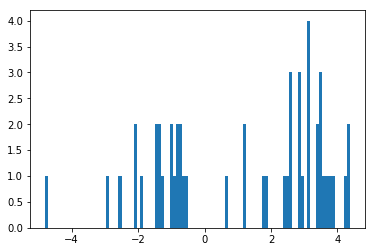

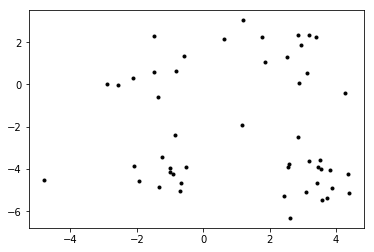

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 objective: 33.86830252608767
Step 10 objective: 0.16855110958805497
Step 20 objective: 7.798693473404228e-05
Step 30 objective: 9.034479298009046e-07
Done with CAVI.


In [6]:
# CAVI can return nu values that are too close to 0 or 1 for the encoding.
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print(np.all(np.isfinite(cavi_params)))

True


In [8]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)
tr_params = deepcopy(vb_opt.x)
tr_tau, tr_phi_mu, tr_phi_var, tr_nu = data_set.unpack_params(tr_params)


Autograd ArrayNode with value 319.233530492 and 1 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 1 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 2 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 2 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 2 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 2 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 2 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.8831125526 and 2 progenitors(s)
Autograd ArrayNode with value 319.233530492 and 2 progenitors(s)
Autograd ArrayNode with value 4.

In [9]:
print ('CAVI:')
print (cavi_phi_mu.transpose())

print ('Full TR:')
tau, phi_mu, phi_var, nu = data_set.unpack_params(tr_params)
print (phi_mu.transpose())

print ('Truth:')
print (A)

CAVI:
[[-1.38893495 -4.01490838]
 [ 2.85744278 -2.84252141]
 [ 2.11953515  1.9052959 ]]
Full TR:
[[-1.38893484 -4.01490835]
 [ 2.85744266 -2.84252138]
 [ 2.11953521  1.90529591]]
Truth:
[[-1.51981911  1.36489297]
 [ 0.07076695 -5.93156821]
 [ 4.53218492  0.19643952]]


Cavi residuals: 63.33308362438211    Trust residuals: 63.33308243737516      True residuals: 78.48308573612925


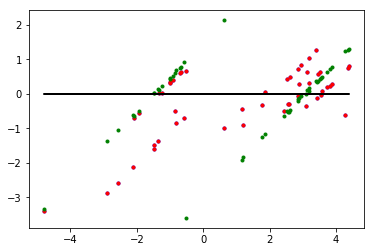

In [12]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(tr_params)
true_resid = data_set.x - np.matmul(Z, A)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], true_resid[:, col], '.g')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}      True residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid)), np.sum(np.abs(true_resid))))


In [13]:
# Compute prior sensitivity, eq. 18 in the paper
moment_sensitivity = data_set.local_prior_sensitivity()

print(moment_sensitivity)
np.shape(moment_sensitivity)

[[  6.71010190e-03  -2.62881180e-05   6.42024383e-03]
 [  9.78672001e-03  -1.29021295e-04   1.03925381e-02]
 [  9.08211057e-03   4.37497820e-04  -4.31875850e-02]
 [ -1.45649864e-03  -3.71388759e-03   8.06211609e-02]
 [ -1.63417586e-03   2.88667967e-03   2.38587264e-01]
 [ -2.15908257e-03   1.02771609e-03  -3.11861157e-01]
 [ -3.25486654e-03  -3.79073712e-03   7.89476959e-02]
 [  1.23064484e-04  -3.01776013e-03   3.24817833e-01]
 [  1.18778774e-03   4.11744146e-03  -2.72958085e-01]]


(9, 3)

In [14]:
# The third column is sigma_eps.
sigma_eps_col = 2
e_log_pi_sigma_eps_sens, e_mu_sigma_eps_sens = \
    packing.unpack_moments(moment_sensitivity[:, sigma_eps_col], k_approx, D)
    
print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

Sensitivity of e_log_pi to sigma_eps:
[ 0.00642024  0.01039254 -0.04318758]
Sensitivity of e_mu to sigma_eps:
[[ 0.08062116  0.23858726 -0.31186116]
 [ 0.0789477   0.32481783 -0.27295809]]


In [15]:
"""# Perturb and re-rerun to check the sensitivity.

epsilon = 1e-1
data_set_perturb = lrvb.DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)
data_set_perturb.trace.print_every = 1
vb_opt_perturb = data_set_perturb.run_newton_tr(tr_params)"""

'# Perturb and re-rerun to check the sensitivity.\n\nepsilon = 1e-1\ndata_set_perturb = lrvb.DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)\ndata_set_perturb.trace.print_every = 1\nvb_opt_perturb = data_set_perturb.run_newton_tr(tr_params)'

In [16]:
"""e_log_pi, e_mu = data_set.get_moments(tr_params)
e_log_pi_perturb, e_mu_perturb = data_set.get_moments(vb_opt_perturb.x)

print('Measured sensitivity of e_mu to sigma_eps:')
print((e_mu_perturb - e_mu) / epsilon)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

print('Measured sensitivity of e_log_pi to sigma_eps:')
print((e_log_pi_perturb - e_log_pi) / epsilon)

print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)
"""

"e_log_pi, e_mu = data_set.get_moments(tr_params)\ne_log_pi_perturb, e_mu_perturb = data_set.get_moments(vb_opt_perturb.x)\n\nprint('Measured sensitivity of e_mu to sigma_eps:')\nprint((e_mu_perturb - e_mu) / epsilon)\n\nprint('Sensitivity of e_mu to sigma_eps:')\nprint(e_mu_sigma_eps_sens)\n\nprint('Measured sensitivity of e_log_pi to sigma_eps:')\nprint((e_log_pi_perturb - e_log_pi) / epsilon)\n\nprint('Sensitivity of e_log_pi to sigma_eps:')\nprint(e_log_pi_sigma_eps_sens)\n"

In [17]:
"""# set up influence function
jac_log_pi_lh = jacobian(data_set.get_log_q_pi, 0)

def g_bar_pi(pi): 
    tmp = np.linalg.solve(kl_hess, jac_log_pi_lh(tr_params, pi))
    return np.dot(moment_jac, tmp)

def Influence_pi(pi, alpha, k_approx): 
    return np.exp(ds.log_q_pi(pi, tr_tau) - ds.log_p0_pi(pi, alpha, k_approx)) * g_bar_pi(pi)"""

'# set up influence function\njac_log_pi_lh = jacobian(data_set.get_log_q_pi, 0)\n\ndef g_bar_pi(pi): \n    tmp = np.linalg.solve(kl_hess, jac_log_pi_lh(tr_params, pi))\n    return np.dot(moment_jac, tmp)\n\ndef Influence_pi(pi, alpha, k_approx): \n    return np.exp(ds.log_q_pi(pi, tr_tau) - ds.log_p0_pi(pi, alpha, k_approx)) * g_bar_pi(pi)'

In [18]:
data_set.influence_function_pi(0.8, 1)

array([ -2.27705538e-10,   2.44877890e-07,   1.20488690e-09,
         3.27308158e-08,  -5.16293037e-08,  -3.47428578e-08,
        -3.18285392e-08,   2.58254269e-08,   4.44071739e-08])

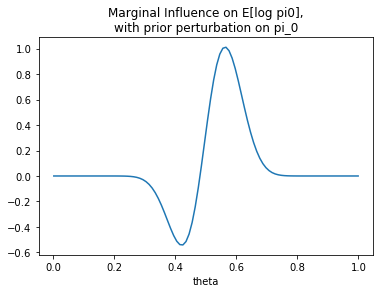

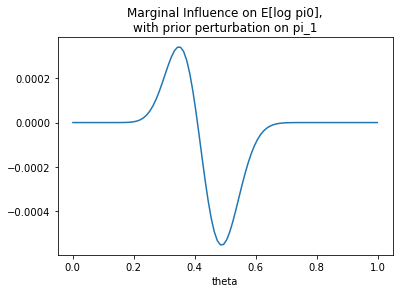

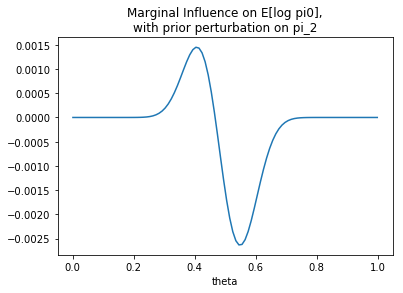

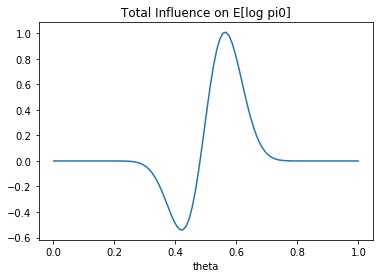

In [19]:
# plot influence function

n_ticks = 100
y = np.zeros((n_ticks, k_approx))

post_pi = 0 # which pi you're looking at in the posterior

theta = np.linspace(0.001,0.999,n_ticks)

for k in range(k_approx):  
    for i in range(n_ticks): 
        y[i, k] = data_set.influence_function_pi(theta[i], k)[post_pi]
        
    plt.plot(theta, y[:,k])
    plt.xlabel('theta')
    plt.title('Marginal Influence on E[log pi' + str(post_pi) + '],\nwith prior perturbation on pi_' + str(k))
    plt.show()

plt.plot(theta, np.sum(y,1))
plt.xlabel('theta')
plt.title('Total Influence on E[log pi' + str(post_pi) + ']')
plt.show()
